# Study of Pupil magnification

## Survey of pupil magnification in lens designs that form *real* images

In [1]:
# imports
from __future__ import print_function, division
import os
import numpy as np
import matplotlib.pyplot as plt
import pyzdde.zdde as pyz
from geometric_model_zemax_commons import * 

In [2]:
%matplotlib inline

### Functions for retrieving and plotting pupil magnification data from Zemax files 

#### Function to retrieve pupil magnification data

Note that irrespective of the Lens Unit set in the lens file, Zemax always returns the focal length in mm, so there is no need to check and/or change the lens unit before getting the focal length.

In [3]:
def get_pupilMagnification_data(ln):
    """return pupil magnification and other relevant data
    
    Parameters
    ----------
    ln : object
        pyzdde object
    
    Returns
    -------
    zFileName : string
        zmx file name (without extension and path)
    zTitle : string
        zmx lens title
    fl : real
        focal length (mm)
    imgFNum : real
        the image space F/# is the infinite conjugate paraxial F/# 
        i.e. eff. focal length / paraxial entrance pupil diameter
    mp : real
        pupil magnification 
    """
    LENS_TITLE = 16
    zfileName = os.path.split(ln.zGetFile())[1].split('.')[0]
    zTitle = ln.zGetSystemProperty(code=LENS_TITLE)
    mp = ln.zGetPupilMagnification()
    imgNAper = ln.zGetImageSpaceNA()
    imgFNum = pyz.numAper2fnum(imgNAper) if imgNAper else np.Inf
    fl = ln.zGetFirst().EFL
    return zfileName, zTitle, fl, imgFNum, mp


#### Function to generate pupil magnification data files

In [4]:
def create_pupil_mag_data_files(dirList):
    """creates text files in the current directory with names
    "pupil_mag_data_xxx.txt". 
    
    Parameters
    ----------
    dirList : list of strings
        list of directory names (strings) under "<curr_dir>\zmxfiles".
        Each directory in the ``dirList`` contain zemax files
        
    Returns
    -------
    None
    
    Notes
    -----
    1. Each file contains data (as shown below) produced from the 
       zmx files present in the directory named "xxx", where, 
       "xxx" are directory names in the ``dirList``, such as 
       "doublegauss", "doubleMeniscus", etc.
    
       Format of pupil magnification data:
    
       FILENAME, LENS TITLE, FOCAL LENGTH (mm), F-NUMBER, PUPIL MAG
    
       E.g. E_001, COOKE TRIPLET ANASTIGMAT, 127.04, 3.50, 1.0197
    
    2. Call this function to generate new data. Data files shall be 
       overwritten.
    """
    currDir = os.path.join(os.getcwd(), 'zmxfiles')
    ln = pyz.createLink()
    for eachDir in dirList:
        eachDirPath = os.path.join(currDir, eachDir)
        fnames = [os.path.join(eachDirPath, zfile)
                  for zfile in os.listdir(eachDirPath) if zfile.lower().endswith(".zmx")]
        txtFileName = 'pupil_mag_data_{}.txt'.format(eachDir)
        with open(txtFileName, 'w') as dfile:
            for eachFile in fnames:
                ln.zLoadFile(eachFile)
                data = get_pupilMagnification_data(ln)
                if data[3] < 5000: # if f-number are < 5000
                    dfile.write('{}, {}, {:0.2f}, {:0.2f}, {:0.4f}\n'
                                .format(data[0], data[1].replace(',','-'),
                                        data[2], data[3], data[4]))
    ln.close()
    print('Created data files in the directory:\n{}'.format(currDir))

#### Function to plot pupil magnification data

In [5]:
def plot_pupil_magnification(dirList, legTxt, cols, which='focalLength', xMax=16, 
                             yMax=None, savefig=False, figFileName=None):
    """function to create a scatter plot from pupil magnification data
    
    Parameters
    ----------
    dirList : list
        list of directory names 
    legTxt : list
        list of legend text
    cols : list
        list of colors
    which : string, optional
        `focalLength` or `fnumber` to plot the pupil mag. against
        focal length or fnumber.
    xMax : real, optional
        the maximum value of pupil magnification to plot
        i.e. maximum x-axis value. The x-axis is always logarithmically
        scaled with base 2.
    yMax : real, optional
        the maximum value of y-axis to plot. If `yMax` > 1000, then the
        y-axis is logarithmically scaled with base 10.
    savefig : bool, optional
        whether to save the figure in the current directory
    figFileName : bool, optional
        filename for the figure if it is going to be saved. If not
        given, then the file name "pupil_mag_plot.png" is used.
        
    Returns
    -------
    None
    """
    if (len(dirList) * len(legTxt) * len(cols) / len(cols)**3) - 1:
        raise ValueError, 'The lists must have equal length!'
    
    curDir = os.getcwd()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    
    # actual plot of the data
    ydataIndex = 3 if which == 'fnumber' else 2
    for i, each in enumerate(dirList):
        txtFileName = os.path.join(curDir, 'pupil_mag_data_{}.txt'.format(each))
        ydata = []
        pupilmag = []
        with open(txtFileName, 'r') as dfile:
            for line in dfile:
                data = line.rstrip().split(',')
                ydata.append(abs(float(data[ydataIndex])))
                pupilmag.append(float(data[4]))
        ax.scatter(pupilmag, ydata, c=cols[i], s=50, alpha=0.7, lw=0.4, label=legTxt[i])

    # figure decorations
    if which == 'focalLength':
        ylabel = 'Focal Length (mm)'
    else:
        ylabel = 'F/# (infinite conjugate)'
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel('Pupil Magnification ($m_p$)', fontsize=14)
    
    #set axis limits
    ax.set_xlim(0, xMax)
    
    if yMax == None:
        yMax = 20.25 if which == 'fnumber' else 250
    
    
    if yMax < 1000: # if yMax > 1000, use log10 scale for y
        yMin = -0.1 if which == 'fnumber' else -5
        ax.set_ylim(yMin, yMax)
    else:
        ax.set_ylim(ymin=0) 
    
    #set spines and tick positions, x-axis scale
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    # scale x-axis
    ax.set_xscale(value='symlog', basex=2, linthreshx=1.0, 
                  subsx=[0.25, 0.5, 0.75, 4, 8])
    ticloc = ax.xaxis.get_ticklocs()
    ax.xaxis.set_ticklabels(ticloc)
    
    # scale y-axis if yMax > 1000
    if yMax > 1000:
        ax.set_yscale(value='symlog', basey=10, linthreshy=1.0)
        ticloc = ax.yaxis.get_ticklocs()
        ax.yaxis.set_ticklabels(ticloc)
    # vertical line at x=1.0 to show mp=1
    ax.axvline(x=1.0, color='k', linestyle='dashed', 
               linewidth=0.7, alpha=0.4)
    # mark x=0.5 if xMax=16
    if xMax==16:
        xtickCol = ax.xaxis.get_ticklabels()[0].get_color()
        xtickFontSize = ax.xaxis.get_ticklabels()[0].get_fontsize()
        fig.text(x=0.243, y=0.075, s='0.5', fontsize=xtickFontSize, color=xtickCol)

    ax.legend(fontsize=12, scatterpoints=1, markerscale=1.0, scatteryoffsets=[0.5])
    
    # 
    if savefig:
        figname = figFileName if figFileName else "pupil_mag_plot.png"
        fig.savefig(figname, dpi=400, bbox_inches='tight', pad_inches=0.04)

    plt.show()

### Pupil magnification data for imaging lenses 

Generate the pupil magnification data for imaging lenses

In [6]:
# Call this function if new data has to be generated.
# Pupil magnification data for imaging lenses in the database
zmxLensDirList = ['doublegauss', 'doubleMeniscus', 
                  'inversetele_retrofocus_wideangle',
                  'microscopeObjectives', 'telephoto', 'triplets']

create_pupil_mag_data_files(zmxLensDirList)

Created data files in the directory:
C:\GIT_REPOSITORIES\phd-artifacts\chapters\chapter03_geometricmodel\code\zmxfiles


##### Plot of focal length vs pupil magnification for imaging lenses 

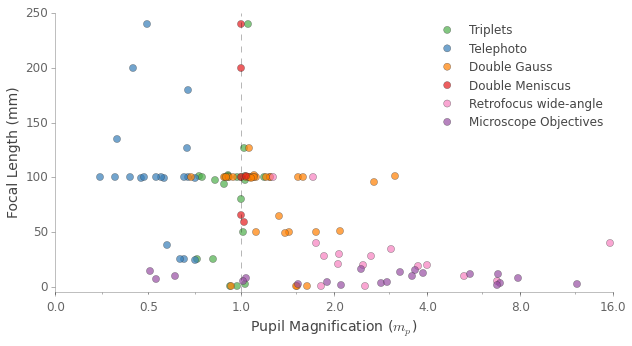

In [9]:
zmxLensDirList = ['triplets', 'telephoto','doublegauss', 'doubleMeniscus',
                  'inversetele_retrofocus_wideangle', 'microscopeObjectives']

legendtxt = ['Triplets', 'Telephoto', 'Double Gauss', 'Double Meniscus',
          'Retrofocus wide-angle', 'Microscope Objectives']

colors = ['#4daf4a', '#377eb8', '#ff7f00', '#e41a1c',  '#f781bf', '#984ea3'] 

plot_pupil_magnification(zmxLensDirList, legendtxt, colors, savefig=False)

##### Plot of F-number vs pupil magnification for imaging lenses 

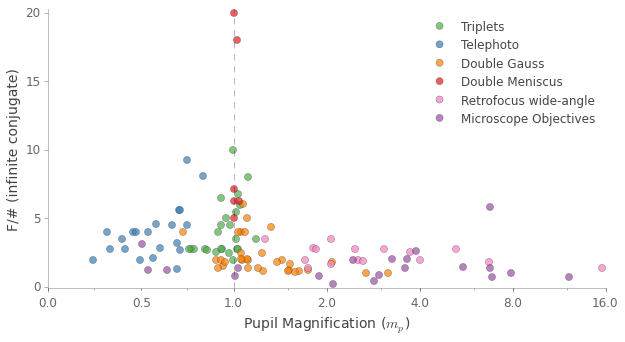

In [10]:
plot_pupil_magnification(zmxLensDirList, legendtxt, colors, which='fnumber')

#### Inference

We can infer the following by observing the plots:

1. There is no correlation between pupil magnification ($m_p$) and focal length or F-number.
2. Telephoto lenses have $m_p < 1.0$ (an explanation follows).
3. Retro-focus wide-angle (or inverse telephoto) lenses have $m_p > 1.0$.
4. Double meniscus lenses, which are tend to be exhibit symmetry about a plane through the lens center, have $m_p \approx 1.0$.  

The (effective) focal length of a normal lens is the distance from the rear principal plane to the plane in which an object at infinity is brought to focus. The distance required to focus an object at a finite distance is greater than the focal length as predicted by the Gaussian lens equation. The rear principal plane is located within the physical extents in a normal lens. Therefore, normal (or "true") long focal length lenses are at least as long as the focal length of the lens. 

To make *long* focal length lenses within a compact body, lens designers employ a negative focal length lens (or a group of elements with net negative focal length) behind a positive focal length lens (or a group of elements with net positive focal length). This system of combined lenses attains a positive *long* focal length within a short body (see [ref] for the governing formulae) and behaves identical to an equivalent true long focal length in terms the geometric characteristics of the image. For example, the length of a 200 mm normal lens would be at least 200 mm (at infinite conjugate). However, combining a 75 mm and a -25 mm focal length lens with a 60 mm separation produces a two-lens system with effective focal length equal to 200 mm and having a back focal length (BFL) of 40 mm. Therefore, the body of this combined lens system is only 100 mm (the separation distance plus the BFL) at infinite conjugate, which is half the length of the true long focal length lens. 

While the negative focal length lens (or group of elements) compacts the design, qua diverging lens, it also forms a diminutive image of the stop viewed from the image side compared to the image of the stop formed by the positive focal length elements viewed from the object side. In other words, a consequence of the telephoto design is that the exit pupil becomes smaller compared to the entrance pupil. Therefore, the pupil magnification for telephoto lenses is less than one. 

On the other hand, retro focus (or inverse telephoto) lens designs employ a negative focal length lens (or group) in front of a positive focal length lens (or group) in order to create sufficient space between the lens and the sensor in short focal length wide angle lenses. This arrangement results in an entrance pupil that is relatively smaller compared to the exit pupil. Therefore, the pupil magnification for retro-focus wide-angle lenses is greater than one.  




In [11]:
# Other statistics
curDir = os.getcwd()
zmxLensDirList = ['triplets', 'telephoto','doublegauss',  
                  'doubleMeniscus', 'microscopeObjectives',
                  'inversetele_retrofocus_wideangle']
pupilmag = []

for i, each in enumerate(zmxLensDirList):
    txtFileName = os.path.join(curDir, 'pupil_mag_data_{}.txt'.format(each))
    with open(txtFileName, 'r') as dfile:
        for line in dfile:
            data = line.rstrip().split(',')
            pupilmag.append(float(data[4]))
            
pupilmag = np.array(pupilmag)

In [12]:
len(pupilmag)

120

In [13]:
# mean and median
print('mean m_p = {:0.4f}, median m_p = {:0.4f}'.format(np.mean(pupilmag), np.median(pupilmag)))

mean m_p = 1.8309, median m_p = 1.0449


In [14]:
# percentage of pupil magnification near 1.0
pupilmagNearOne = np.sum(np.logical_and(0.95 < pupilmag, pupilmag < 1.05)) # within 5% of 1.0
percentagePupilmagNearOne = np.round((100*pupilmagNearOne)/len(pupilmag))
print('Number of lenses = {}\n% of lenses = {:0.0f}'.format(pupilmagNearOne, percentagePupilmagNearOne))

Number of lenses = 20
% of lenses = 17


In [15]:
1/6 # one is six lens

0.16666666666666666

In [16]:
# percentage of pupil magnification greater than 0.5
pupilmagGrt05 = np.sum(pupilmag > 0.5)
percentagepupilmagGrt05 = np.round((100*pupilmagGrt05)/len(pupilmag))
print('Number of lenses = {}\n% of lenses = {:0.0f}'.format(pupilmagGrt05, percentagepupilmagGrt05))

Number of lenses = 112
% of lenses = 93


### Pupil magnification data for imaging and non-lenses 

#### Pupil magnification of afocal systems and beam expanders

In [17]:
# Pupil magnification data for afocals, and beam-expanders
zmxLensDirList = ['afocal_beamexpanders',]

create_pupil_mag_data_files(zmxLensDirList)

Created data files in the directory:
C:\GIT_REPOSITORIES\phd-artifacts\chapters\chapter03_geometricmodel\code\zmxfiles


In [18]:
curDir = os.getcwd()
print('\tLens name\t\t\tPupil magnification')
for i, each in enumerate(zmxLensDirList):
    txtFileName = os.path.join(curDir, 'pupil_mag_data_{}.txt'.format(each))
    with open(txtFileName, 'r') as dfile:
        for line in dfile:
            data = line.rstrip().split(',')
            lensName = data[1].replace('-', ',')
            print('{:.<50}{:2.4f}'.format(lensName, float(data[4])))

	Lens name			Pupil magnification
 5X HENE BEAM EXPANDER............................4.9981
 50X HENE BEAM EXPANDER...........................50.0041
 4X TELESCOPE.....................................0.2563
 ALBADA VIEWFINDER................................1.2920
 2X ANAMORPHIC LENS...............................1.9882
 Front conversion afocal, example 1, 4929068......0.7149
 Viewfinder, zoom, embodiment 1, 4906078..........2.1836


#### Pupil magnification of mirror telescopes and catadioptric systems

In [19]:
# Pupil magnification data for mirror telescopes and catadioptric systems
zmxLensDirList = ['mirror_telescopes_catadioptric',]
create_pupil_mag_data_files(zmxLensDirList)

Created data files in the directory:
C:\GIT_REPOSITORIES\phd-artifacts\chapters\chapter03_geometricmodel\code\zmxfiles


In [20]:
curDir = os.getcwd()
focallength = []
pupilmag = []
for i, each in enumerate(zmxLensDirList):
    txtFileName = os.path.join(curDir, 'pupil_mag_data_{}.txt'.format(each))
    with open(txtFileName, 'r') as dfile:
        for line in dfile:
            data = line.rstrip().split(',')
            focallength.append(abs(float(data[2])))
            pupilmag.append(float(data[4]))
            
pupilmag = np.array(pupilmag)
focallength = np.array(focallength)

In [21]:
print('Number of lenses:', len(focallength))
print('Maximum value of focal length:', np.max(focallength))
print('Minimum value of focal length:', np.min(focallength))
print('Maximum value of pupil magnification:', np.max(pupilmag))
print('Minimum value of pupil magnification:', np.min(pupilmag))


Number of lenses: 75
Maximum value of focal length: 57611.92
Minimum value of focal length: 4.0
Maximum value of pupil magnification: 303.364
Minimum value of pupil magnification: 0.0633


Plot the pupil magnification data for the mirror telescopes and catadioptric lenses

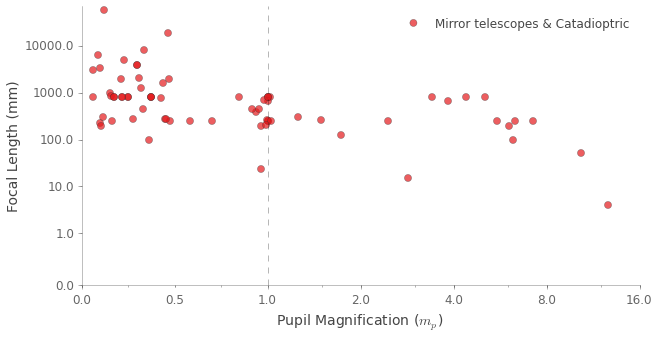

In [22]:
zmxLensDirList = ['mirror_telescopes_catadioptric',]
legendtxt = ['Mirror telescopes & Catadioptric', ]
colors = ['#e41a1c',] 

plot_pupil_magnification(zmxLensDirList, legendtxt, colors, xMax=16, yMax=6000)

## Effect of lens tilts and pupil magnification on image distortions 

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1 

In [3]:
# imports
from __future__ import print_function, division
import os
import numpy as np
import matplotlib.pyplot as plt
import pyzdde.zdde as pyz
%matplotlib inline

In [4]:
%aimport geometric_model_zemax_commons
from geometric_model_zemax_commons import * 

In [7]:
curDir = os.getcwd()
# Location of the Zemax lens files for this notebook
zmxdir = os.path.join(curDir, 'zmxfiles')
ln = pyz.createLink()

We load a 

In [8]:
lens = "paraxialDoubleLens_mp1_infConj.zmx"
lensPath = os.path.join(zmxdir, lens)
ln.zLoadFile(lensPath)
draw_pupil_cardinal_planes(ln, firstDummySurfOff=40, push=True)

Exit pupil distance from IMG: -40.0
Entrance pupil from Surf 1: 30.0
Focal plane obj:  -10.0 
Focal plane img:  0.0
Principal plane obj:  30.0 
Principal plane img:  -40.0
Focal length:  40.0
Principal plane H to ENPP:  0.0
Principal plane H' to EXPP:  0.0
u =  0.0
v = None


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'